In [1]:
#Visualize Samples from the model
import sys,os,glob
sys.path.append('../../')
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth']=5
mpl.rcParams['lines.markersize']=10
mpl.rcParams['text.latex.unicode']=True
mpl.rcParams['text.usetex']=True
mpl.rcParams['font.family'] = 'serif' 
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['text.latex.preamble']= ['\\usepackage{amsfonts}','\\usepackage{amsmath}']
mpl.rcParams['font.size'] = 40
mpl.rcParams['axes.labelsize']=40
mpl.rcParams['legend.fontsize']=40
#http://stackoverflow.com/questions/22408237/named-colors-in-matplotlib
from utils.misc import getConfigFile, readPickle, loadHDF5, getUniqueIDFromParams
from optvaeutils.viz import getName

DIR      = '../../expt/chkpt-wikicorp';
MAXEPOCH = '50'
numfeats = ['_1000','_5000','_10000','']
otypes   = ['none','finopt']

short_names = {}
if os.path.exists('../../optvaeutils/default-hmap.pkl'):
    short_names = readPickle('../../optvaeutils/default-hmap.pkl')[0]
colors = {}
colors[0] = 'r'
colors[1] = 'b'
colors[2] = 'g'
colors[3] = 'k'
colors[4] = 'y'
colors[5] = 'k'
colors[6] = 'm'
colors[7] = 'c'
colors[8] = 'b'

markers = {}
markers[0]= '*'
markers[1]= '<'
markers[2]= '>'
markers[3]= '8'
markers[4]= 'p'
markers[5]= 'v'
markers[6]= '3'
markers[7]= '2'
markers[8]= '4'

#Evalaute POB 
from datasets.load import loadDataset
from optvaedatasets.load import loadDataset as loadDataset_OVAE
dataset        =DIR.split('chkpt-')[1]
print 'Dataset:', dataset
dset = loadDataset_OVAE(dataset)

Loading linear matrices
Loading linear matrices
Dataset: wikicorp
Read  3  objects


In [2]:
#Visualize Training Curves (train/valid/test) across different 
datalist, l_params, namelist, svallist = [],[],[],[]
ctr = 0

results = {}
results_train = {}
for nfeat in numfeats:
    if len(nfeat)==0:
        N = str(dset['train'].shape[1])
    else:
        N = str(nfeat[1:])
    results[N] = {}
    results_train[N] = {}
    for otype in otypes:
        NEWDIR = DIR+nfeat+'-'+otype+'/'
        for f in glob.glob(NEWDIR+'*EP'+MAXEPOCH+'*.h5'):
            params = readPickle(getConfigFile(f))[0]
            if 'pl-0' in f or params['anneal_rate']>100:
                continue
            params['replicate_K'] = None
            name   = getName(params)
            print name+str(params['anneal_rate'])
            data   = loadHDF5(f)
            l_params.append(params)
            datalist.append(data)
            namelist.append(name)
            assert 'valid_perp_0' in data,'recheck'
            min_0 = np.min(data['valid_perp_0'][:,1])
            min_f = np.min(data['valid_perp_f'][:,1])
            amin  = np.argmin(data['valid_perp_f'][:,1])
            epmin = data['valid_perp_f'][amin,0]
            print N,otype,min_0,min_f
            results[N][otype] = min_f
            Y = data['train_perp_f'][:,1]
            Y = Y[~np.isnan(Y)]
            min_f = np.min(Y)
            print min_f
            results_train[N][otype] = min_f

Read  1  objects
baseline0
1000 none 302.870675133 289.591739706
288.173552089
Read  1  objects
fin1000
1000 finopt 299.345819299 275.46578753
273.67834278
Read  1  objects
baseline0
5000 none 837.002384559 786.204869762
774.412562508
Read  1  objects
fin1000
5000 finopt 794.640207551 713.994501902
702.724079186
Read  1  objects
baseline0
10000 none 1159.10712011 1072.68255847
1046.83925145
Read  1  objects
fin1000
10000 finopt 1073.99289771 949.805815148
925.015912045
Read  1  objects
Read  1  objects
baseline0
20000 none 1477.2710467 1339.22622251
1277.70146691
Read  1  objects
Read  1  objects
Read  1  objects
Read  1  objects
fin1000
20000 finopt 1387.93840148 1191.3619986
1135.31371966
Read  1  objects
Read  1  objects
fin1000
20000 finopt 1362.68343003 1175.70214735
1122.49518258


In [3]:
diff_valid = 1
bar_names_label=[]
bar_names  = []
for nfeat in numfeats:
    if len(nfeat)==0:
        N = dset['train'].shape[1]
    else:
        N = int(nfeat[1:])
    bar_names.append(str(N))
    bar_names_label.append(str(N/1000)+'k')

[0 1 2 3] [0.050300276356339178, 0.092571436457118184, 0.11637253688809426, 0.12147304229367094]
[0.048778850496256382, 0.091846757299509363, 0.11455089145540569, 0.1221034000219508]


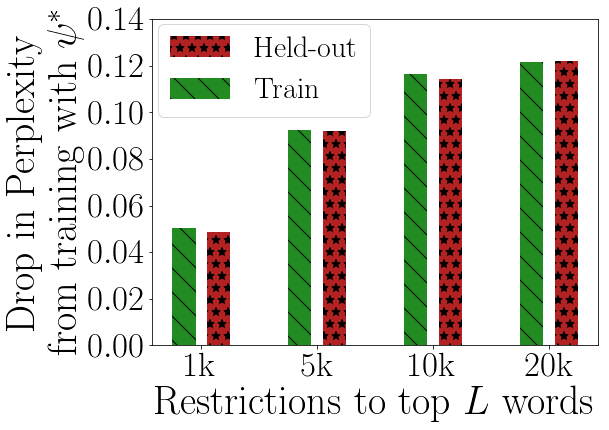

In [8]:
diff      = [(results[N]['none']-results[N]['finopt'])/(results[N]['none']) for N in bar_names]
diff_train  = [(results_train[N]['none']-results_train[N]['finopt'])/(results_train[N]['none']) for N in bar_names]
n_groups  = len(diff)
#fig, ax = plt.subplots(figsize=(20,22))
fig, ax = plt.subplots(figsize=(8,6))

index = np.arange(n_groups)
bar_width = 0.2

error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index+0.15, diff, bar_width,
                 color='firebrick',
                 error_kw=error_config,
                 label='Held-out', hatch='*')

print index, diff_train
print diff
rects1 = plt.bar(index-0.15, diff_train, bar_width,
                 color='forestgreen',
                 error_kw=error_config,
                 label='Train', hatch='\\')

plt.xlabel('Restrictions to top $L$ words',fontsize=40)
plt.ylabel('Drop in Perplexity\n from training with $\\psi^*$',fontsize=40)#: $\\frac{P[\\psi(x)]-P [\\psi_{\\text{opt}}]}{P[\\psi(x)]}$',
          #)#, y=1.)
plt.xticks(index , bar_names_label,fontsize=35)
plt.legend(loc='upper center', bbox_to_anchor=(0.25, 1.03),fontsize=35,frameon=True, prop={'size': 30})
plt.yticks(np.arange(0,0.15,0.02),fontsize=35)
fname = 'wikicorp_features.pdf'
plt.savefig(fname, bbox_inches='tight')